In [11]:
import rawpy
import scipy.ndimage as ndi
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [12]:
# set input path
path_in = 'L1004220.DNG'

In [13]:
# filename for JPEG output
path_out  = path_in.split('.')[0] + '.jpg'
path_out

'L1004220.jpg'

In [14]:
# read 16-bit integer data from RAW file into raw_image array
with rawpy.imread(path_in) as raw:
    raw_image = raw.raw_image.copy()

In [15]:
# GREEN KERNEL
green_kernel = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
]) / 4.0

# RED KERNEL
red_kernel = np.array([
    [1, 0, 1],
    [0, 0, 0],
    [1, 0, 1]
]) / 4.0

# BLUE KERNEL
blue_kernel = np.array([
    [1, 0, 1],
    [0, 0, 0],
    [1, 0, 1]
]) / 4.0

# max value of unsigned 16-bit integer = 65535
raw_float = raw_image.astype(np.float32) / 65535.0  # Normalizes 16-bit raw image to a float between 0 and 1

# Interpolate the pixels
red = ndi.correlate(raw_float, red_kernel, mode='mirror')
green = ndi.correlate(raw_float, green_kernel, mode='mirror')
blue = ndi.correlate(raw_float, blue_kernel, mode='mirror')

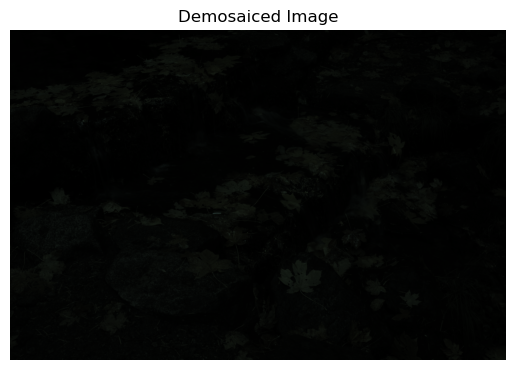

In [16]:
height, width = raw_float.shape

# mask arrays with all zero values
red_mask = np.zeros_like(raw_float, dtype=bool)
green_mask = np.zeros_like(raw_float, dtype=bool)
blue_mask = np.zeros_like(raw_float, dtype=bool)

# RGGB pattern:
# 0::2 means "start at index 0, and take every 2nd element"
# (0, 0), (0, 2), (2, 0), (2, 2)
red_mask[0::2, 0::2] = True         # Red at even rows, even cols
green_mask[0::2, 1::2] = True       # Green at even rows, odd cols
green_mask[1::2, 0::2] = True       # Green at odd rows, even cols
blue_mask[1::2, 1::2] = True        # Blue at odd rows, odd cols

# Overwrite interpolated values with actual sensor values
# This preserves the original sensor data where available, using interpolation only for the missing color information at each pixel.
red[red_mask] = raw_float[red_mask]
green[green_mask] = raw_float[green_mask]
blue[blue_mask] = raw_float[blue_mask]

# stack color channels and add new axis to end of stack
# Shape: (H, W, 3)
rgb_image = np.stack([red, green, blue], axis=-1)

plt.imshow(np.clip(rgb_image, 0, 1))  # Clip values to [0, 1] range
plt.title("Demosaiced Image")
plt.axis('off')
plt.show()

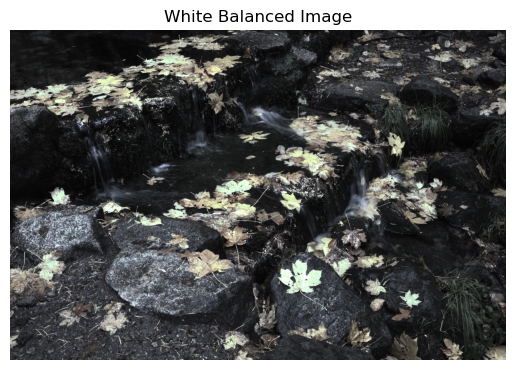

In [17]:
# Calculate the mean of each channel (R, G, B)
mean_red = np.mean(rgb_image[:, :, 0])
mean_green = np.mean(rgb_image[:, :, 1])
mean_blue = np.mean(rgb_image[:, :, 2])

# Calculate a scaling factor for each channel
scaler_red = .25 / mean_red
scaler_green = .25 / mean_green
scaler_blue = .25 / mean_blue

# Apply scaling to each channel
wb_rgb_image = np.zeros_like(rgb_image)
wb_rgb_image[:, :, 0] = rgb_image[:, :, 0] * scaler_red  # Red channel
wb_rgb_image[:, :, 1] = rgb_image[:, :, 1] * scaler_green  # Green channel
wb_rgb_image[:, :, 2] = rgb_image[:, :, 2] * scaler_blue  # Blue channel

# Clip values to the range [0, 1] and visualize the result
plt.imshow(np.clip(wb_rgb_image, 0, 1))
plt.title("White Balanced Image")
plt.axis('off')
plt.show()

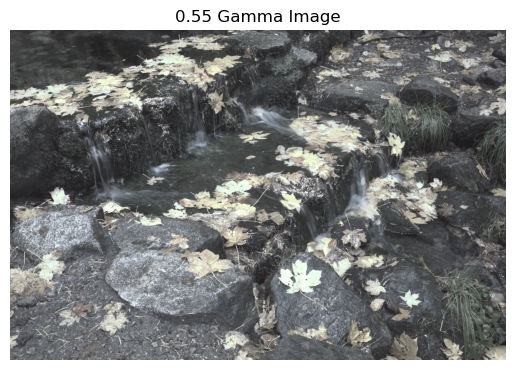

In [18]:
gamma_image = wb_rgb_image ** 0.55
plt.imshow(np.clip(gamma_image, 0, 1))  # Clip values to [0, 1] range
plt.title("0.55 Gamma Image")
plt.axis('off')
plt.show()

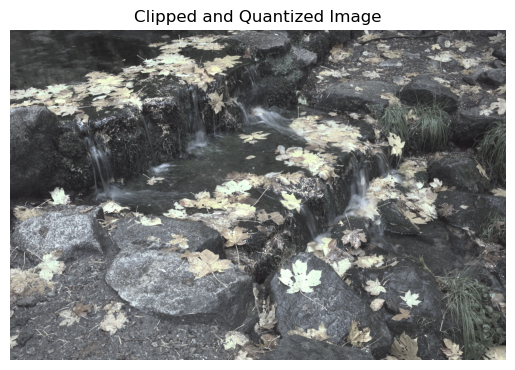

In [19]:
clip_quantized_image = (np.clip(gamma_image, 0, 1) * 255).astype(np.uint8)
plt.imshow(clip_quantized_image)
plt.title("Clipped and Quantized Image")
plt.axis('off')
plt.show()

In [20]:
imageio.imwrite(path_out, clip_quantized_image)